Order of action
1. Revalue BDI swaps
2. Deisel cost pass through 
3. Bonus price contract freight phosphate
4. Deisel Force Majeure 
5. Spread 
6. Phosphate cargoes (shipping vs freight)

In [39]:
# 1. Revalue Bdi Swaps 
"""
Possible FACTORS:
- Settlement date rollover misalignment
- Maturity dates
- Underlying shipment goes through Atlantic into the Gulf of Mexico | Hedged for a panama canal transfer 
- 0.1 multiplier for BDI
- Inconsistent tanker size hedged, implicit of BDI swap
The Baltic Dry Index (BDI) is the successor to the Baltic Freight Index (BFI) and came into operation on 1 November 1999. 
Since 1 March 2018, the index is a weighted average of the Capesize 40pct, 
Panamax 30pct and Supramax 30pct Timecharter Averages which is then multiplied by a multiplier of 0.1.


ERRORS:
2 possible discrepencies in location:
1. The BDI is a global index, but the underlying shipment is specified to go through the Atlantic into the Gulf of Mexico. 
So GCW is paying higher rate on fixed, for a currently low variable swap rate
2. The BDI swap is fairly priced for Morocco > New Orleans, but the shipments to suppliers go through panama canal into S.America. 
"""

#Revaluation of new hedge BDI Swaps 
import math 
N = 4 # Number of deltaI's
r = 0.045
deltaI = 1 / 4 # Accrual factor for BDI Swaps
Ffixed = 0 # fixed swap rate --Will solve for this--
Findex = [28.79,28.79,28.78,28.65]# variable annualized swap rate, based on BDI, would be adjusted to be dollar notional per ton
V = 100 # Notional index volume (approximately assumes the # of tons in the route calculation, accounting for a 0.1 multiplier)
Discount_factors = [math.exp(-r * (90 * (i+1) / 360)) for i in range(N)] # Discount factor for the swap valuation, at each deltaI period
# at open settlement date, fixed rate = index rate 
# currently, the fixed rate is higher than the index rate, causing the sharp spike in hedge losses
numerator = sum(Findex[i] * deltaI * Discount_factors[i] for i in range(N))
denominator = sum(deltaI * Discount_factors[i] for i in range(N)) 
Ffixed = numerator / denominator # New fixed rate, based on the average of the index rates
print("New fixed rate for BDI swaps per ton: ", Ffixed)

""""
Step-by-step explanation of calculating the fixed swap rate for freight swaps (no code):

1. **Define the number of payment periods and accrual factor:**  
   Determine how many payment periods (N) there are (e.g., quarterly payments means N=4) and the accrual factor per period (fraction of year each period represents, e.g., 0.25 for quarterly).

2. **Obtain the floating freight rates for each period:**  
   Have the expected floating rates (Findex) for each payment period, usually annualized rates quoted in $/ton.

3. **Set the annual discount rate:**  
   Use the annual discount rate (r) representing the relevant interest rate environment for discounting future cash flows.

4. **Calculate the discount factor for each payment date:**  
   For each period, calculate how far in the future the payment is (in years), then compute the discount factor as the present value weight using continuous compounding:  
   $$
   D_{t,T_i} = e^{-r \times t_i}
   $$  
   where $$t_i$$ is the time to period $$i$$ in years.

5. **Calculate the present value (PV) of the floating leg:**  
   Multiply each floating rate by its corresponding accrual factor and discount factor, then sum these across all periods:  
   $$
   PV_{\text{floating}} = \sum_{i=1}^N F_{\text{index}, i} \times \Delta_i \times D_{t,T_i}
   $$

6. **Calculate the present value of the fixed leg accruals:**  
   Sum the accrual factors discounted by the corresponding discount factors:  
   $$
   PV_{\text{fixed accrual}} = \sum_{i=1}^N \Delta_i \times D_{t,T_i}
   $$

7. **Calculate the fixed swap rate:**  
   Divide the floating leg PV by the discounted accrual sum to find the fair fixed rate that makes the swap value zero at inception:  
   $$
   F_{\text{fix}} = \frac{PV_{\text{floating}}}{PV_{\text{fixed accrual}}}
   $$

8. **Interpret the fixed swap rate:**  
   This rate represents the fixed freight cost per ton that balances expected floating payments discounted to present value, ensuring neither party has an initial advantage.

""""

<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\s'
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_52772/747163363.py:37: SyntaxWarning: invalid escape sequence '\s'
  """"


SyntaxError: unterminated string literal (detected at line 77) (747163363.py, line 77)

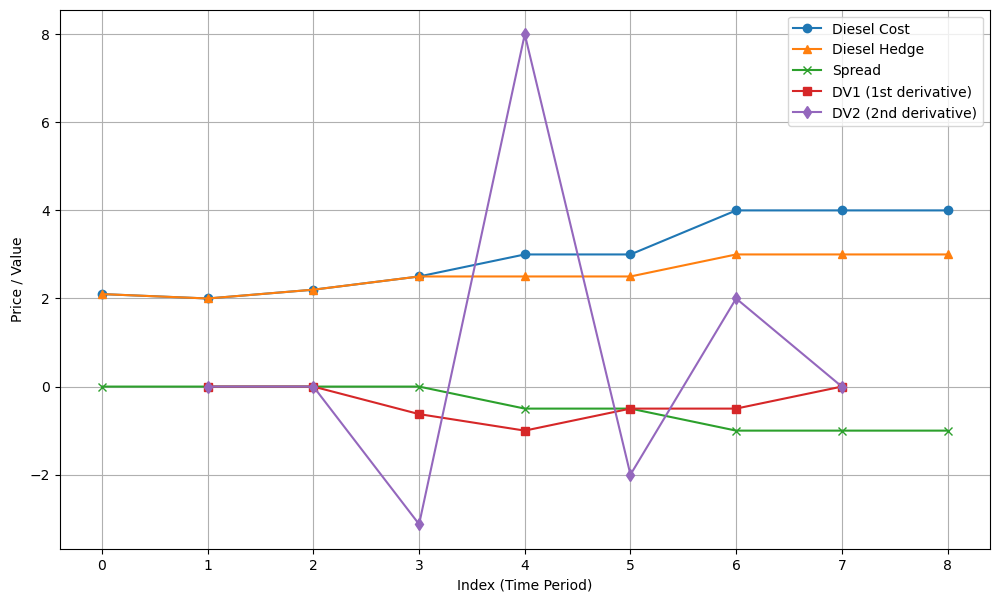

In [42]:
# 2. Physical deisel cost pass through hedges slipping 
"""The underlying deisel cost has increased, which causes the hedge to slip. GCW has variable exposure to deisel, while the hedge should set a fixed rate for GCW,
, It is likely that the underlying cost pass through caused an exponential increase in exposure for the linear hedge created that GCW currently has. 

Revaluation:(Assuming deisel went from $2 to $4)
- Use a taylor series expansion to approximate the new value of the hedge, given the change in underlying cost for both new and old hedges.
Contract FACTORS: 
- Hedge could have a cap 
- No theta bc of pass-through 
- Vega on the contract, but not for the underlying cost for deisel spread
- Gamma is causing hedge discrepency, as the underlying cost is not linear, but the hedge is linear
- Specs
Basis FACTORS:
- Hedge may be mispricing: 
- Regionality
- Transportation 
- Type 
- Quality
- Contract type (e.g., fixed vs variable)
- Volume / delivery schedule
"""
# Solution: Fix the futures contract OR Option hedge with non-linear gamma. 
# To solve, use central differencing in a taylor series expansion to approximate the new value of the hedge, given the change in underlying cost for both new and old hedges.
# Central differencing is just the mean change between the two (close) points, with x as a spot price, and y as the contract value. Is the same as finding secant line. 
# f(x+h) is that minute small addition to x, while f(x-h) is the left side of x, f(x) is current value at x 
import matplotlib.pyplot as plt

Deiselcost = [2.1, 2, 2.2, 2.5, 3, 3, 4, 4, 4]
Deiselhedge = [2.1, 2, 2.2, 2.5, 2.5, 2.5, 3, 3, 3]

spread = [Deiselhedge[i] - Deiselcost[i] for i in range(len(Deiselhedge))]

DV1 = [
    round(
        (spread[i + 1] - spread[i - 1]) / (Deiselcost[i + 1] - Deiselcost[i - 1] + 1e-10),
        6
    )
    for i in range(1, len(Deiselcost) - 1)
]

DV2 = [
    round(
        (spread[i + 1] - 2 * spread[i] + spread[i - 1]) / (((Deiselcost[i + 1] - Deiselcost[i - 1]) / 2) ** 2 + 1e-10),
        6
    )
    for i in range(1, len(Deiselcost) - 1)
]

# Compute midpoints for derivatives x-axis
x_dv = [
    (Deiselcost[i - 1] + Deiselcost[i + 1]) / 2
    for i in range(1, len(Deiselcost) - 1)
]

plt.figure(figsize=(12, 7))

x_index = list(range(len(Deiselcost)))       # x for full data like cost, hedge, spread
x_dv_index = list(range(1, len(Deiselcost)-1))  # x for DV1 and DV2 derivatives

plt.plot(x_index, Deiselcost, label='Diesel Cost', marker='o')
plt.plot(x_index, Deiselhedge, label='Diesel Hedge', marker='^')
plt.plot(x_index, spread, label='Spread', marker='x')
plt.plot(x_dv_index, DV1, label='DV1 (1st derivative)', marker='s')
plt.plot(x_dv_index, DV2, label='DV2 (2nd derivative)', marker='d')

plt.xlabel('Index (Time Period)')

plt.ylabel('Price / Value')
plt.legend()
plt.grid(True)
plt.show()
